In [1]:
from acquire_timeseries import acquire_timeseries
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random as python_random

2023-03-28 19:34:53.135809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 19:34:53.256272: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28 19:34:53.729824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 19:34:53.729876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def create_dataset_plain(time_series, n_lags, n_forecasts):
    time_series = time_series.to_numpy()
    X = []
    Y = []
    for t in range(len(time_series) - n_lags - n_forecasts + 1):
        x = time_series[t: t + n_lags].copy()
        X.append(x)
        if n_forecasts == 1:
            y = time_series[t + n_lags]
        else:
            y = time_series[t + n_lags: t + n_lags + n_forecasts].copy()
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, Y

def create_dataset(time_series, n_lags, n_forecasts, test_len):
    X, Y = create_dataset_plain(time_series, n_lags, n_forecasts)
    Xtrain = X[:-test_len]
    Ytrain = Y[:-test_len]
    Xtest = X[-test_len:]
    Ytest = Y[-test_len:]
    return Xtrain, Ytrain, Xtest, Ytest

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


In [3]:
ds_group_ts = acquire_timeseries(
    input_csv='group_samples/group_popularity_until_13.02.2023.csv',
    input_format='DAOD',  # AOD
    input_subformat='SUSY',  # TOPQ HIGG SUSY PHYS
    input_project='mc16_13TeV'  # data16_13TeV
)
ds_group_ts

2018-01-01     102
2018-01-08     694
2018-01-15    1445
2018-01-22    1041
2018-01-29    1315
              ... 
2023-01-16     443
2023-01-23     790
2023-01-30    2472
2023-02-06     907
2023-02-13     775
Length: 268, dtype: int64

<AxesSubplot: >

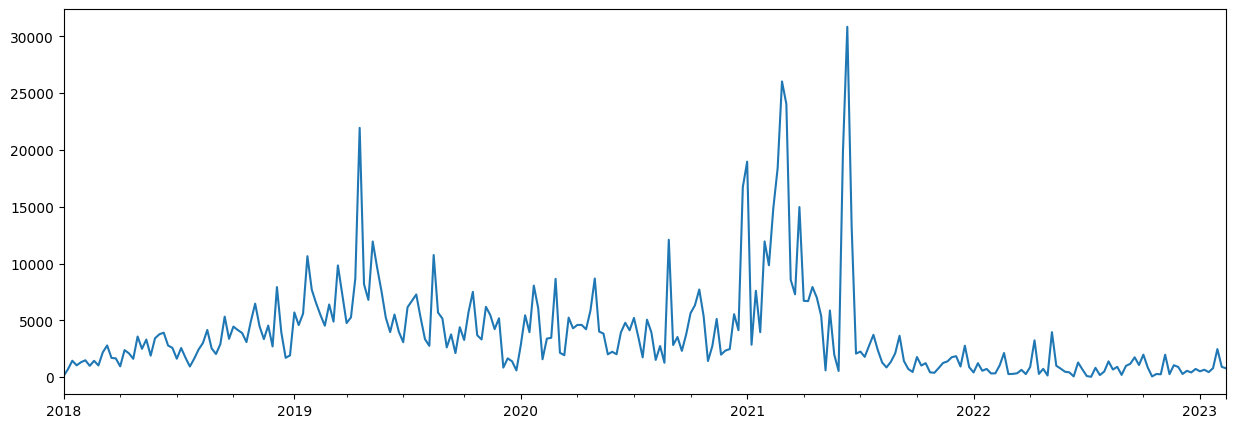

In [4]:
ds_group_ts.plot(figsize=(15, 5))

In [5]:
log_ts = np.log(ds_group_ts + 1)
log_ts

2018-01-01    4.634729
2018-01-08    6.543912
2018-01-15    7.276556
2018-01-22    6.948897
2018-01-29    7.182352
                ...   
2023-01-16    6.095825
2023-01-23    6.673298
2023-01-30    7.813187
2023-02-06    6.811244
2023-02-13    6.654153
Length: 268, dtype: float64

In [6]:
diff_log_ts = log_ts.diff().dropna()
diff_log_ts

2018-01-08    1.909183
2018-01-15    0.732645
2018-01-22   -0.327659
2018-01-29    0.233455
2018-02-05    0.122164
                ...   
2023-01-16   -0.385753
2023-01-23    0.577473
2023-01-30    1.139889
2023-02-06   -1.001943
2023-02-13   -0.157092
Length: 267, dtype: float64

In [7]:
n_lags = 32
n_forecasts = 1
ntest = 12

Xtrain, Ytrain, Xtest, Ytest = create_dataset(diff_log_ts, n_lags, n_forecasts, ntest)

Ytest

array([-0.15605363, -1.17477365,  0.69673785, -0.29127274,  0.55170517,
       -0.34062449,  0.23741023, -0.38575257,  0.57747341,  1.1398893 ,
       -1.00194289, -0.15709186])

In [8]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(24, input_shape=(n_lags, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

2023-03-28 19:34:55.242013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 19:34:55.246845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-28 19:34:55.246866: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-28 19:34:55.247302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Epoch 1/100
7/7 [==============================] - 2s 60ms/step - loss: 0.8487 - val_loss: 0.4178
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8356 - val_loss: 0.4110
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8235 - val_loss: 0.4044
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8118 - val_loss: 0.3978
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8013 - val_loss: 0.3914
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.7905 - val_loss: 0.3854
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7788 - val_loss: 0.3797
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.7684 - val_loss: 0.3745
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 0.7579 - val_loss: 0.3677
Epoch 10/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7477 - val_loss: 0.3598
Epoch 11/100
7/7 [=========

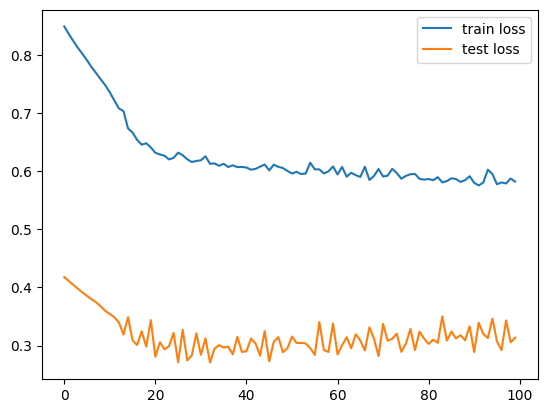

In [9]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [10]:
train_idx = ds_group_ts.index[1 + n_lags: 1 + n_lags + len(Ytrain)]
test_idx = ds_group_ts.index[1 + n_lags + len(Ytrain):]

Ytrain_predicted = model.predict(Xtrain).flatten()
Ytest_predicted = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 14ms/step


In [11]:
prev = log_ts.shift().dropna()
Ytrain_predicted_log = Ytrain_predicted + prev[train_idx].to_numpy()
Ytest_predicted_log = Ytest_predicted + prev[test_idx].to_numpy()

In [12]:
smape_log = smape(log_ts[test_idx], Ytest_predicted_log)
print(f'{smape_log=}')

mape_log = 100 * mean_absolute_percentage_error(log_ts[test_idx], Ytest_predicted_log)
print(f'{mape_log=}')

smape_log=6.004640291696639
mape_log=5.777790128254554


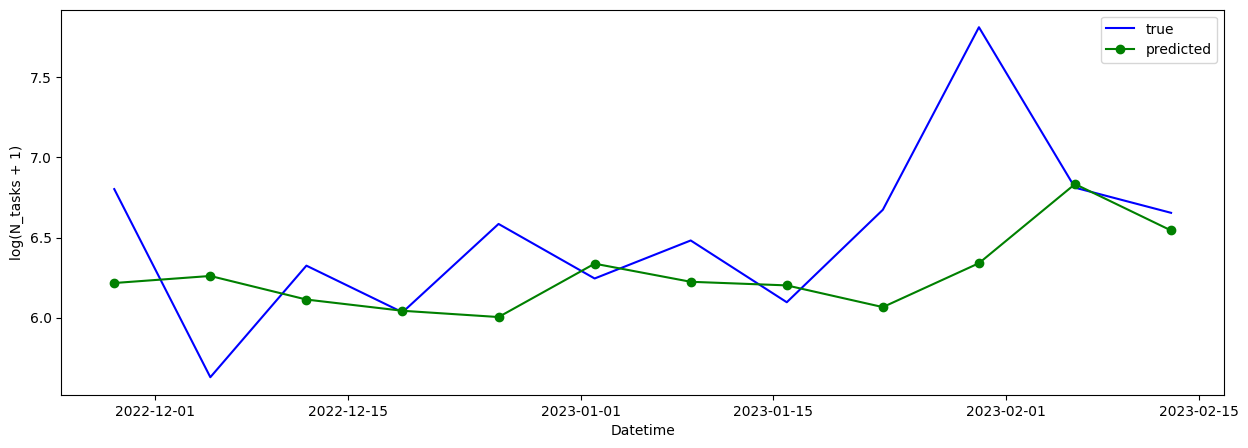

In [13]:
# Plot prediction on log()

fig, ax = plt.subplots()
fig.set(figwidth=15, figheight=5)
ax.set(xlabel='Datetime', ylabel='log(N_tasks + 1)')
ax.plot(log_ts[test_idx], '-', color='blue', label='true')
ax.plot(test_idx, Ytest_predicted_log, 'o-', color='green', label='predicted')
plt.legend()
plt.show()

In [14]:
results = pd.DataFrame({'log_ntasks' : log_ts})
results.loc[train_idx, 'train_predicted'] = Ytrain_predicted_log
results.loc[test_idx, 'test_predicted'] = Ytest_predicted_log

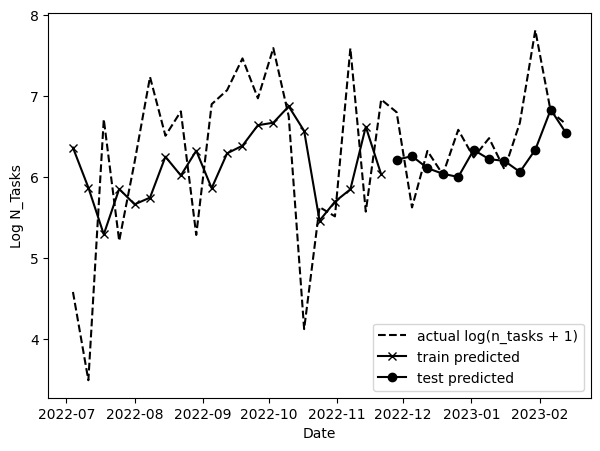

In [15]:
fig, ax = plt.subplots()
fig.set(figwidth=7, figheight=5)
ax.set(xlabel='Date', ylabel='Log N_Tasks')

ax.plot(results['log_ntasks']['2022-07-01' : ], '--', color='black', label='actual log(n_tasks + 1)')
ax.plot(results['train_predicted']['2022-07-01' : ], 'x-', color='black', label='train predicted')
ax.plot(results['test_predicted'], 'o-', color='black', label='test predicted')
plt.legend()
plt.show()

In [16]:
# fig.savefig('../../lstm-susy-one-step.eps', bbox_inches='tight')

In [17]:
n_multistep = 12

multistep_predictions = []

last_x = Xtest[-n_multistep]

while len(multistep_predictions) < n_multistep:
    p = model.predict(tf.expand_dims(last_x, axis=0))[0]

    multistep_predictions.append(p)

    last_x = np.roll(last_x, -1)
    last_x[-1] = p

prev_value = log_ts[-n_multistep - 1]

multistep_idx = ds_group_ts.index[-n_multistep:]

multistep_y_pred_log = prev_value + np.cumsum(multistep_predictions)
results.loc[multistep_idx, 'multistep'] = multistep_y_pred_log

1/1 [==============================] - 0s 16ms/step


In [18]:
multistep_idx

DatetimeIndex(['2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19',
               '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16',
               '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13'],
              dtype='datetime64[ns]', freq=None)

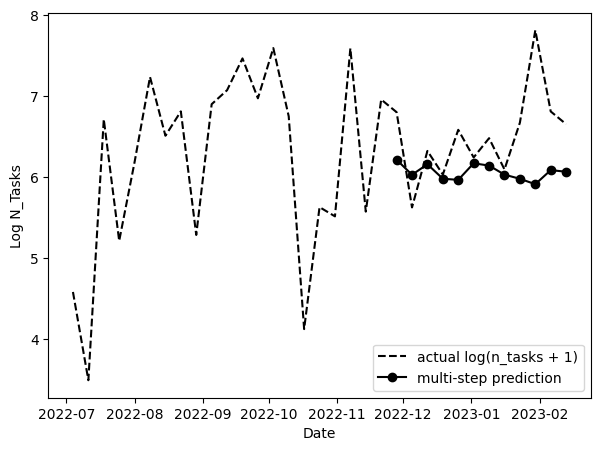

In [19]:
fig, ax = plt.subplots()
fig.set(figwidth=7, figheight=5)
ax.set(xlabel='Date', ylabel='Log N_Tasks')

ax.plot(results['log_ntasks']['2022-07-01' : ], '--', color='black', label='actual log(n_tasks + 1)')
ax.plot(results['multistep'], 'o-', color='black', label='multi-step prediction')
plt.legend()
plt.show()

In [20]:
smape_log_multistep = smape(results['log_ntasks'][multistep_idx],
                             results['multistep'][multistep_idx])
print(f'{smape_log_multistep=}')

mape_log_multistep = 100 * \
    mean_absolute_percentage_error(results['log_ntasks'][multistep_idx],
                                   results['multistep'][multistep_idx])

print(f'{mape_log_multistep=}')

smape_log_multistep=7.989156405206039
mape_log_multistep=7.512188974105262


In [21]:
# fig.savefig('../../lstm-susy-multi-step.eps', bbox_inches='tight')

In [22]:
n_forecasts = n_multistep

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)


model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.LSTM(24, input_shape=(n_lags, 1),  return_sequences=True))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(n_forecasts))
model2.compile(loss='mse', optimizer='adam')

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32, 24)            2496      
                                                                 
 global_max_pooling1d (Globa  (None, 24)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
Total params: 2,796
Trainable params: 2,796
Non-trainable params: 0
_________________________________________________________________


In [23]:
ntest = 10
Xtrain2, Ytrain2, Xtest2, Ytest2 = create_dataset(diff_log_ts, n_lags, n_forecasts, ntest)

Ytest2

array([[-0.49211229,  0.61932727, -0.84176882, -2.62396708,  1.5040774 ,
        -0.11375889,  2.07238862, -2.01389241,  1.38249929, -0.15605363,
        -1.17477365,  0.69673785],
       [ 0.61932727, -0.84176882, -2.62396708,  1.5040774 , -0.11375889,
         2.07238862, -2.01389241,  1.38249929, -0.15605363, -1.17477365,
         0.69673785, -0.29127274],
       [-0.84176882, -2.62396708,  1.5040774 , -0.11375889,  2.07238862,
        -2.01389241,  1.38249929, -0.15605363, -1.17477365,  0.69673785,
        -0.29127274,  0.55170517],
       [-2.62396708,  1.5040774 , -0.11375889,  2.07238862, -2.01389241,
         1.38249929, -0.15605363, -1.17477365,  0.69673785, -0.29127274,
         0.55170517, -0.34062449],
       [ 1.5040774 , -0.11375889,  2.07238862, -2.01389241,  1.38249929,
        -0.15605363, -1.17477365,  0.69673785, -0.29127274,  0.55170517,
        -0.34062449,  0.23741023],
       [-0.11375889,  2.07238862, -2.01389241,  1.38249929, -0.15605363,
        -1.17477365,  

In [24]:
r = model.fit(Xtrain2, Ytrain2, epochs=100, validation_data=(Xtest2, Ytest2))

Epoch 1/100
7/7 [==============================] - 1s 67ms/step - loss: 1.0624 - val_loss: 1.6244
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 1.0302 - val_loss: 1.5009
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.9692 - val_loss: 1.4231
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9183 - val_loss: 1.3798
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9020 - val_loss: 1.3541
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.8913 - val_loss: 1.3360
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 0.8841 - val_loss: 1.3231
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8790 - val_loss: 1.3140
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8756 - val_loss: 1.3072
Epoch 10/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8731 - val_loss: 1.3016
Epoch 11/100
7/7 [========

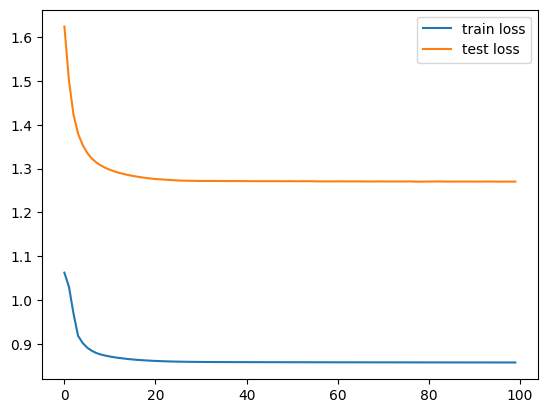

In [25]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [26]:
y_pred_diff = model2.predict(tf.expand_dims(Xtest[-1], axis=0))
y_pred_diff = y_pred_diff[0]

y_pred_log = np.cumsum(y_pred_diff) + log_ts[-n_forecasts - 1]

results.loc[multistep_idx, 'multi-output'] = y_pred_log

results

1/1 [==============================] - 0s 245ms/step


,log_ntasks,train_predicted,test_predicted,multistep,multi-output
2018-01-01,4.634729,NaN,NaN,NaN,NaN
2018-01-08,6.543912,NaN,NaN,NaN,NaN
2018-01-15,7.276556,NaN,NaN,NaN,NaN
2018-01-22,6.948897,NaN,NaN,NaN,NaN
2018-01-29,7.182352,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-01-16,6.095825,NaN,6.201052,6.031813,6.586751
2023-01-23,6.673298,NaN,6.065441,5.980724,6.551669
2023-01-30,7.813187,NaN,6.339668,5.914205,6.659341
2023-02-06,6.811244,NaN,6.833700,6.087644,6.488669


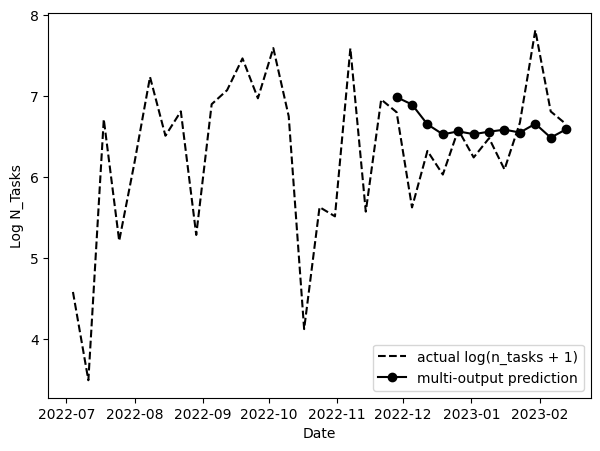

In [27]:
fig, ax = plt.subplots()
fig.set(figwidth=7, figheight=5)
ax.set(xlabel='Date', ylabel='Log N_Tasks')

ax.plot(results['log_ntasks']['2022-07-01' : ], '--', color='black', label='actual log(n_tasks + 1)')
ax.plot(results['multi-output'], 'o-', color='black', label='multi-output prediction')
plt.legend()
plt.show()

In [28]:
# fig.savefig('../../lstm-susy-multi-output.eps', bbox_inches='tight')

In [29]:
y_pred_diff_test = model2.predict(Xtest2)

smape_multiout = 0.0
mape_multiout = 0.0

for i in range(len(Xtest2)):
    prev_value = log_ts[-(len(Xtest2) - i + n_forecasts)]
    y_pred_log_cur = np.cumsum(y_pred_diff_test[i]) + prev_value
    actual = log_ts[-(len(Xtest2) - i - 1 + n_forecasts) : ]
    actual = actual[ : n_forecasts]
    smape_multiout += smape(actual, y_pred_log_cur)
    mape_multiout += 100 * mean_absolute_percentage_error(actual, y_pred_log_cur)

smape_multiout /= len(Xtest2)
print(f"{smape_multiout=}")
mape_multiout /= len(Xtest2)
print(f"{mape_multiout=}")

1/1 [==============================] - 0s 245ms/step
smape_multiout=19.1335677064397
mape_multiout=18.47491974869339
